In [1]:
import numpy as np
import pandas as pd
from helper import get_car_paths, get_cars_df, get_car_data, get_effnet
import random

from fastai.vision import *

In [2]:
def seed_all(seed=42):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)

seed_all(seed=42)

# Load Data

In [3]:
# If the data does not exist yet (first run), `get_car_paths` will automatically
# download and unzip all the data into correct folders.
train_path, test_path = get_car_paths()
train_df = get_cars_df('cars_train_annos.mat')
test_df = get_cars_df('cars_test_annos_withlabels.mat')

In [4]:
print(f"Path to train data: {str(train_path.resolve())}")
print(f"Path to test data: {str(test_path.resolve())}")

Path to train data: /home/zw91/Projects/ai4sea/Data/cars_train
Path to test data: /home/zw91/Projects/ai4sea/Data/cars_test


In [5]:
train_df.head()

,fname,class_name,class
0,00001.jpg,Audi TTS Coupe 2012,14
1,00002.jpg,Acura TL Sedan 2012,3
2,00003.jpg,Dodge Dakota Club Cab 2007,91
3,00004.jpg,Hyundai Sonata Hybrid Sedan 2012,134
4,00005.jpg,Ford F-450 Super Duty Crew Cab 2012,106


In [6]:
test_df.head()

,fname,class_name,class
0,00001.jpg,Suzuki Aerio Sedan 2007,181
1,00002.jpg,Ferrari 458 Italia Convertible 2012,103
2,00003.jpg,Jeep Patriot SUV 2012,145
3,00004.jpg,Toyota Camry Sedan 2012,187
4,00005.jpg,Tesla Model S Sedan 2012,185


# Intro to Fastai Library

## Data
To train an image classifier using fastai library, we need to instantiate a `ImageDataBunch` object. ImageDataBunch binds train, valid and test dataloaders together. Here, we create an ImageDataBunch using `from_df` method. This method automatically splits the dataset into train_dl and valid_dl with ratio defined by `valid_pct`.

One thing to note is the `size` argument. It can be an integer or a tuple of 2 integers (see [docs](https://docs.fast.ai/vision.transform.html)):
- if `size=300` is passed, it will resize and then crop to (300,300)
- if `size=(300,300)` is passed, it will squish (not crop) it to (300,300). Squish means stretching the shorter side/compressing the longer side.

From my experiments, I found that squish works better for this dataset.

`get_transforms()` is a convinient function to get a list of transforms for the train and validation set. `tfms = (train_tfms_list, valid_tfms_list)` (see [doc](https://docs.fast.ai/vision.transform.html) for more info).

By defaults (with no arguments):
- For the train set, common data augmentations will be applied,e.g. random crop, flip, rotate, zoom, adjust brightness/contrast. 
- For the validation set, only center crop / squish will be applied

`tfms` is then passed to the `ds_tfms` keyword to create a ImageDataBunch object. The transformations will be applied on the fly during data loading.

We also normalize the data using imagenet stats by using `normalize(imagenet_stats)` method. (`imagenet_stats` was imported when we did `from fastai.vision import *`)

In [7]:
sz = (300, 300)    #final image size as the input of the model
bs = 64    #batch size
tfms = get_transforms()
data = ImageDataBunch.from_df(
    train_path, train_df, ds_tfms=tfms, size=sz, 
    fn_col=0, label_col=1, valid_pct=0.2, bs=bs, 
    padding_mode="reflection").normalize(imagenet_stats)

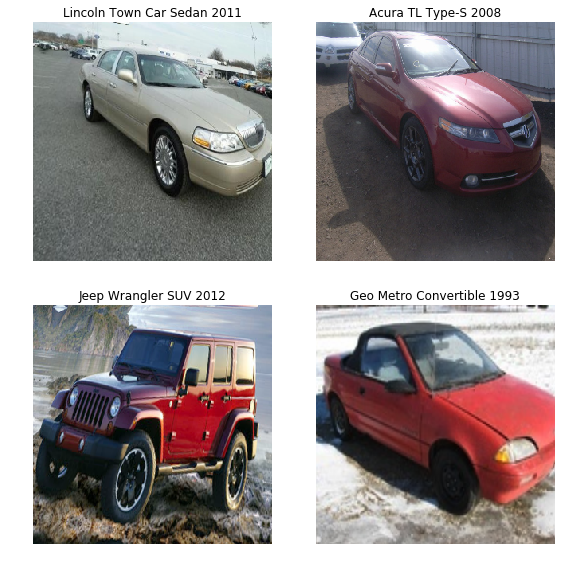

In [8]:
# Show some transformed images of the train set
data.show_batch(rows=2, ds_type=DatasetType.Train)

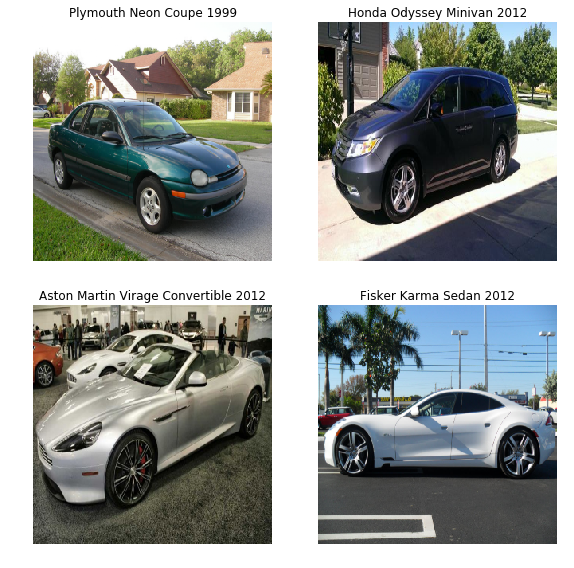

In [9]:
# Show some transformed images of the valid set
data.show_batch(rows=2, ds_type=DatasetType.Valid)

## Learner

`Learner` is an object in fastai to train a `model` using `data` to minimize `loss_func` with optimizer `opt_func`. To create a CNN learner, `cnn_learner` function can be used, which supports most of the pretrained models from [torchvision.models](https://pytorch.org/docs/stable/torchvision/models.html). It automatically replace the old head (the layers after the last conv layer) with a new head with correct number of outputs (inferred from `data`).

A few things to note:
- if `pretrained=True`, the model is freezed up to the head.
- the default `opt_func` is Adam. If `true_wd=True` which is the default, it uses methods from [Decoupled Weight Decay Regularization](https://arxiv.org/abs/1711.05101) to fix the weight decay regularization in Adam (L2 and weight decay regularization are equivalent for SGD, but not for Adam).

In [10]:
# Create a Learner with pretrained Resnet-50
learn = cnn_learner(
    data, 
    models.resnet50, 
    pretrained=True,
    true_wd=True,
    loss_func=nn.CrossEntropyLoss(), 
    metrics=[accuracy], 
    path='.', callback_fns=ShowGraph)

In [11]:
# Check the head
learn.model[-1]

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten()
  (2): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25)
  (4): Linear(in_features=4096, out_features=512, bias=True)
  (5): ReLU(inplace)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5)
  (8): Linear(in_features=512, out_features=196, bias=True)
)

In [12]:
# Use mixed precision training
learn.to_fp16()

Learner(data=ImageDataBunch;

Train: LabelList (6516 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
Audi TTS Coupe 2012,Acura TL Sedan 2012,Dodge Dakota Club Cab 2007,Hyundai Sonata Hybrid Sedan 2012,Ford F-450 Super Duty Crew Cab 2012
Path: Data/cars_train;

Valid: LabelList (1628 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
Plymouth Neon Coupe 1999,Honda Odyssey Minivan 2012,Aston Martin Virage Convertible 2012,Fisker Karma Sedan 2012,Audi S6 Sedan 2011
Path: Data/cars_train;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


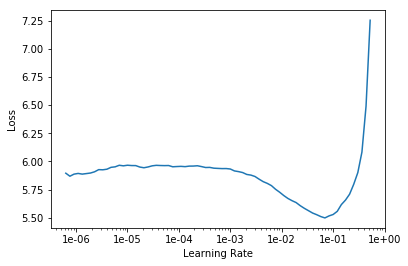

In [13]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,3.931158,3.652251,0.171376,00:48
1,2.224479,1.526326,0.600737,00:46


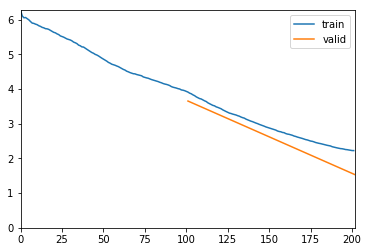

In [14]:
epochs = 2
lr = 1e-2
wd = 1e-3
learn.fit_one_cycle(epochs, max_lr=lr, wd=wd, div_factor=25, pct_start=0.3)

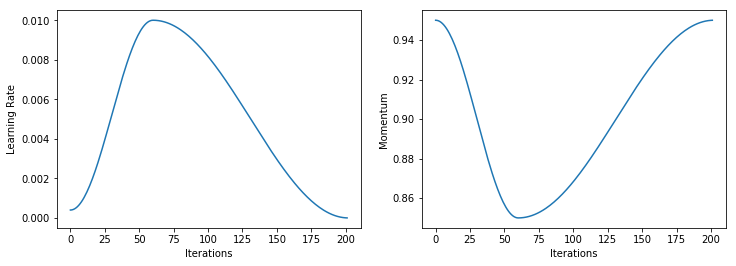

In [15]:
learn.recorder.plot_lr(show_moms=True)

In [17]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


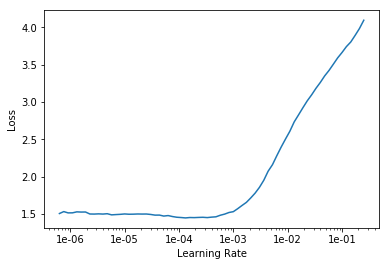

In [18]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,1.389446,1.426890,0.628378,00:57
1,1.187183,1.119474,0.726658,00:55
2,0.837210,0.885665,0.775184,00:56
3,0.631765,0.846721,0.792383,00:54


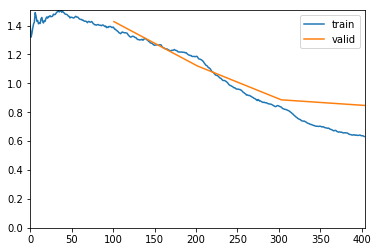

In [19]:
epochs = 4
lr = 1e-4
wd = 1e-3
learn.fit_one_cycle(epochs, max_lr=lr, wd=wd, div_factor=25, pct_start=0.3)

In [27]:
learn.save('all_trained_2')

# B0

In [3]:
try:
    learn.destroy()
    del learn
    gc.collect()
except Exception as e:
    print(e)

name 'learn' is not defined


In [4]:
xtra_tfms = zoom_crop(scale=(0.75,1.5), do_rand=True) + [cutout(n_holes=(1,4), length=(10, 40), p=0.7)]
tfms = get_transforms(xtra_tfms=xtra_tfms)
train_val_data = get_car_data(dataset="train", tfms=tfms, bs=32, sz=(300, 300), 
                                     padding_mode="reflection", stratify=True, seed=42)

In [5]:
eff_net = get_effnet(name="efficientnet-b0", pretrained=True, n_class=196)
learn = Learner(train_val_data, eff_net, loss_func=LabelSmoothingCrossEntropy(), 
                metrics=[accuracy], path='.', callback_fns=ShowGraph).mixup(alpha=0.3)
learn.to_fp16()

Getting pretrained efficientnet-b0
Loaded pretrained weights for efficientnet-b0


Learner(data=ImageDataBunch;

Train: LabelList (6515 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
Audi TTS Coupe 2012,Acura TL Sedan 2012,Dodge Dakota Club Cab 2007,Hyundai Sonata Hybrid Sedan 2012,Geo Metro Convertible 1993
Path: Data/cars_train;

Valid: LabelList (1629 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
Ford Ranger SuperCab 2011,Toyota 4Runner SUV 2012,Aston Martin V8 Vantage Convertible 2012,Suzuki SX4 Sedan 2012,Audi RS 4 Convertible 2008
Path: Data/cars_train;

Test: None, model=EfficientNet(
  (_conv_stem): Conv2dSamePadding(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dSamePadding(32, 32, kernel_size=

epoch,train_loss,valid_loss,accuracy,time
0,5.275451,5.095333,0.055862,00:58
1,4.909654,4.382066,0.153468,00:58
2,4.256559,3.268149,0.360958,00:58
3,3.498153,2.491757,0.546961,00:58
4,3.062843,2.206061,0.618785,00:59
5,2.780822,2.089022,0.651320,00:59
6,2.670955,2.085671,0.652548,00:58
7,2.608799,2.343323,0.586863,00:59
8,2.673570,2.262903,0.624309,00:59
9,2.667144,2.416893,0.559239,00:58


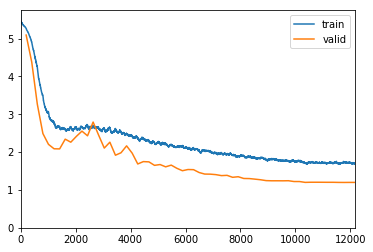

In [6]:
lr = 3e-3
wd = 1e-3
epochs = 60
learn.fit_one_cycle(epochs, max_lr=lr, wd=wd, div_factor=25, final_div=1e4)

In [7]:
learn.save("effnet-B0_best")

In [8]:
learn.export("exported_models/effnet-b0_best.pkl")

# Resnet50

In [3]:
try:
    learn.destroy()
    del learn
    gc.collect()
except Exception as e:
    print(e)

name 'learn' is not defined


In [4]:
xtra_tfms = zoom_crop(scale=(0.75,1.5), do_rand=True) + [cutout(n_holes=(1,4), length=(10, 40), p=0.5)]
tfms = get_transforms(xtra_tfms=xtra_tfms)
train_val_data = get_car_data(dataset="train", tfms=tfms, bs=64, sz=(300, 300), 
                                     padding_mode="reflection", stratify=True, seed=42)

In [5]:
learn = cnn_learner(train_val_data, models.resnet50, metrics=[accuracy], 
                    loss_func=LabelSmoothingCrossEntropy(), path='.', callback_fns=ShowGraph).mixup(alpha=0.2)
learn = learn.to_fp16()

epoch,train_loss,valid_loss,accuracy,time
0,5.241146,4.186966,0.179251,00:50
1,4.271204,3.027340,0.391651,00:47
2,3.663414,2.816318,0.419890,00:46
3,3.465575,3.045598,0.389196,00:47
4,3.354128,2.993587,0.389810,00:47
5,3.187025,2.627083,0.476366,00:47
6,3.058147,2.406534,0.562922,00:47
7,2.932290,2.431994,0.574586,00:47
8,2.797466,2.080938,0.665439,00:47
9,2.680992,2.030779,0.675261,00:47


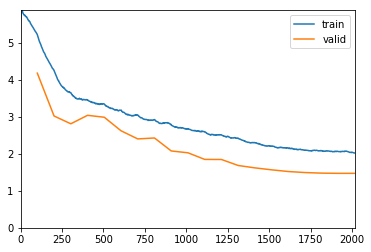

In [6]:
lr = 1e-2
wd = 1e-5
learn.fit_one_cycle(20, max_lr=lr, wd=wd, div_factor=25, pct_start=0.3)

In [7]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,time
0,2.127317,1.486911,0.860651,00:54
1,2.081613,1.532060,0.840393,00:54
2,2.140081,1.649445,0.800491,00:55
3,2.210527,1.811566,0.748312,00:54
4,2.288229,1.871794,0.741559,00:55
5,2.343690,1.961768,0.697974,00:54
6,2.375243,2.192783,0.621854,00:54
7,2.401954,1.973268,0.694291,00:54
8,2.399491,2.135754,0.640270,00:54
9,2.378631,1.853820,0.732965,00:54


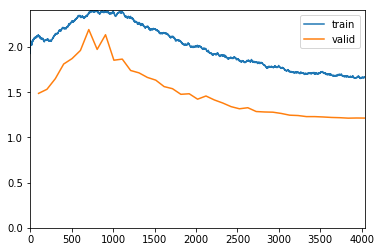

In [8]:
lr = 3e-3
wd = 1e-5
learn.fit_one_cycle(40, max_lr=slice(lr/10, lr), wd=wd, div_factor=25, pct_start=0.3)

In [9]:
learn.save("resnet50_best")

In [10]:
learn.export("exported_models/resnet50_best.pkl")

# Test Runs

In [1]:
import train

In [3]:
n_runs = 6
epochs_per_run = 60
model_name="efficientnet-b0"
train.train_n_runs(n_runs, epochs_per_run, model_name=model_name)

Test accuracy: 		0.92380

Metrics history
   val_loss  val_acc  test_loss  test_acc    time(s)
0    1.1672   0.9288     1.1861    0.9231  3483.0701
1    1.2368   0.9153     1.1894    0.9255  3494.4408
2    1.1656   0.9294     1.1794    0.9248  3443.4641
3    1.1656   0.9245     1.1900    0.9229  3451.8481
4    1.1976   0.9233     1.1919    0.9223  3457.2173
5    1.1805   0.9214     1.1897    0.9238  3462.5909

Average metrics over 6 runs
   val_loss  val_acc  test_loss  test_acc    time(s)
0    1.1856   0.9238     1.1877    0.9237  3465.4386


In [2]:
n_runs = 6
epochs_per_run = 60
model_name="resnet-50"
train.train_n_runs(n_runs, epochs_per_run, model_name=model_name)

Test accuracy: 		0.92505

Metrics history
   val_loss  val_acc  test_loss  test_acc    time(s)
0    1.2445   0.9202     1.2193    0.9299  3123.7032
1    1.2310   0.9227     1.2252    0.9241  3118.0967
2    1.2138   0.9343     1.2251    0.9259  3112.3457
3    1.2162   0.9276     1.2224    0.9265  3123.4251
4    1.2387   0.9196     1.2219    0.9269  3114.1514
5    1.2239   0.9196     1.2290    0.9250  3138.9071

Average metrics over 6 runs
   val_loss  val_acc  test_loss  test_acc    time(s)
0     1.228    0.924     1.2238    0.9264  3121.7715


# Test Runs

## Efficientnet-B0

In [1]:
!python train.py -m efficientnet-b0 -n 8

Your selected model is efficientnet-b0, performing 8 training runs...

Training Run #1
Getting pretrained efficientnet-b0
Loaded pretrained weights for efficientnet-b0

Training efficientnet-b0 for 60 epochs...
epoch     train_loss  valid_loss  accuracy  time    
0         5.268177    5.116731    0.039288  00:57                       
1         4.915954    4.415504    0.143033  00:56                       
2         4.229703    3.269360    0.356661  00:56                       
3         3.432420    2.637910    0.518723  00:56                       
4         3.008642    2.198227    0.622468  00:56                       
5         2.746657    2.046867    0.667281  00:57                       
6         2.668028    2.072784    0.659300  00:56                       
7         2.638936    2.182145    0.630448  00:56                       
8         2.633600    2.041384    0.671578  00:56                       
9         2.643142    2.263003    0.622468  00:56                        
10   

39        1.876333    1.268395    0.906691  00:57                        
40        1.870969    1.241707    0.907919  00:57                        
41        1.880345    1.233444    0.917127  00:56                        
42        1.835336    1.239016    0.916513  00:57                        
43        1.801840    1.235731    0.913444  00:57                        
44        1.811852    1.209094    0.918355  00:57                        
45        1.796318    1.210909    0.918355  00:57                        
46        1.774704    1.207430    0.926335  00:57                        
47        1.761714    1.188854    0.925107  00:56                        
48        1.757798    1.183724    0.931246  00:57                        
49        1.760732    1.178509    0.936157  00:56                        
50        1.733868    1.169004    0.933088  00:57                        
51        1.730460    1.168257    0.935543  00:57                        
52        1.752246    1.162774    0.93

17        2.533544    1.992215    0.695519  00:57                        
18        2.469840    2.224349    0.639042  00:57                        
19        2.452491    1.956835    0.711479  00:57                        
20        2.381664    1.821935    0.753223  00:57                        
21        2.397165    1.725886    0.771025  00:57                        
22        2.363050    1.766799    0.758134  00:56                        
23        2.285381    1.769496    0.764273  00:57                        
24        2.232884    1.703659    0.790669  00:56                        
25        2.240471    1.559952    0.820135  00:56                        
26        2.206348    1.564309    0.814610  00:57                        
27        2.207041    1.613656    0.811541  00:57                        
28        2.173236    1.492486    0.836710  00:56                        
29        2.084378    1.454648    0.848373  00:57                        
30        2.081636    1.431873    0.86

Test accuracy: 		0.92380                             

Training Run #6
Getting pretrained efficientnet-b0
Loaded pretrained weights for efficientnet-b0

Training efficientnet-b0 for 60 epochs...
epoch     train_loss  valid_loss  accuracy  time    
0         5.261738    5.074305    0.049724  00:57                       
1         4.909159    4.391139    0.163904  00:56                       
2         4.195417    3.185976    0.393493  00:57                       
3         3.434868    2.368633    0.574586  00:57                       
4         2.945433    2.155533    0.638429  00:56                       
5         2.764269    2.167322    0.643953  00:57                       
6         2.676946    1.991598    0.686925  00:57                       
7         2.639681    2.000404    0.680172  00:57                       
8         2.666133    2.351193    0.601596  00:57                       
9         2.661384    2.348497    0.596685  00:57                        
10        2.726325   

39        1.900910    1.340395    0.883364  00:57                        
40        1.872844    1.331427    0.887047  00:56                        
41        1.859460    1.276339    0.907305  00:57                        
42        1.834207    1.299485    0.885819  00:57                        
43        1.794828    1.242867    0.906077  00:57                        
44        1.813270    1.239257    0.911602  00:57                        
45        1.806447    1.233340    0.913444  00:56                        
46        1.771976    1.235560    0.918355  00:57                        
47        1.773058    1.204521    0.919583  00:57                        
48        1.792466    1.198564    0.920196  00:57                        
49        1.765346    1.202032    0.925107  00:57                        
50        1.724195    1.201105    0.922652  00:57                        
51        1.733661    1.193558    0.923880  00:57                        
52        1.731397    1.190013    0.92

## Resnet-50

In [2]:
!python train.py -m resnet-50 -n 8

Your selected model is resnet-50, performing 8 training runs...

Training Run #1

Training resnet-50 for 20 + 40 epochs...
Phase 1, training head...
epoch     train_loss  valid_loss  accuracy  time    
0         5.193850    4.198626    0.167587  00:50                       
1         4.265569    3.125562    0.373849  00:45                       
2         3.615352    2.813791    0.439533  00:46                       
3         3.482910    2.861683    0.445058  00:46                       
4         3.362022    2.989501    0.411909  00:46                       
5         3.208197    2.709125    0.457950  00:46                       
6         3.003619    2.483636    0.538981  00:46                       
7         2.909260    2.356485    0.580110  00:49                       
8         2.806090    2.110572    0.674647  00:48                       
9         2.702239    2.044848    0.689380  00:45                        
10        2.572448    1.855159    0.739104  00:46                  

18        2.039079    1.475494    0.852670  00:54                        
19        2.030220    1.472871    0.865562  00:53                        
20        1.976452    1.444903    0.858195  00:54                        
21        1.947218    1.403588    0.879681  00:53                        
22        1.922176    1.412266    0.871700  00:54                        
23        1.912084    1.364897    0.891958  00:54                        
24        1.862918    1.325597    0.895028  00:54                        
25        1.853801    1.322432    0.902394  00:54                        
26        1.814708    1.318869    0.903622  00:54                        
27        1.809156    1.289523    0.914672  00:54                        
28        1.771255    1.272087    0.914058  00:54                        
29        1.759514    1.263700    0.911602  00:54                        
30        1.747565    1.264048    0.916513  00:54                        
31        1.734900    1.245854    0.91

16        2.106716    1.514717    0.861265  00:46                        
17        2.065160    1.496420    0.868017  00:46                        
18        2.065627    1.492430    0.866789  00:46                        
19        2.031055    1.490399    0.873542  00:45                        
Phase 2, unfreezed and training the whole model...
epoch     train_loss  valid_loss  accuracy  time    
0         2.057592    1.519579    0.851443  00:53                       
1         2.080024    1.590073    0.836710  00:53                       
2         2.108657    1.675744    0.802333  00:54                       
3         2.204879    1.830408    0.731737  00:53                       
4         2.281317    1.803396    0.767342  00:54                       
5         2.330097    1.951028    0.710866  00:54                       
6         2.399173    2.037170    0.696133  00:54                       
7         2.382191    2.130154    0.658072  00:54                       
8         2.4148

38        1.670092    1.248392    0.931246  00:55                        
39        1.673129    1.248876    0.931246  00:54                        
Training completed!

Validation accuracy: 	0.93125

Evaluating on test set...
Test accuracy: 		0.92443                             

Training Run #6

Training resnet-50 for 20 + 40 epochs...
Phase 1, training head...
epoch     train_loss  valid_loss  accuracy  time    
0         5.283925    4.183405    0.163904  00:47                       
1         4.263733    3.045925    0.385513  00:46                       
2         3.622654    2.901683    0.421117  00:47                       
3         3.511657    2.735874    0.471455  00:47                       
4         3.367225    2.893839    0.416820  00:46                       
5         3.230346    2.434781    0.570289  00:46                       
6         3.039978    2.388569    0.568447  00:46                       
7         2.903770    2.287747    0.594230  00:46                      

15        2.146649    1.627684    0.815224  00:55                        
16        2.129266    1.508473    0.847759  00:54                        
17        2.087738    1.495953    0.858195  00:54                        
18        2.048853    1.513900    0.846532  00:54                        
19        1.999342    1.471973    0.864948  00:54                        
20        1.992090    1.440960    0.866176  00:54                        
21        1.947334    1.436450    0.865562  00:55                        
22        1.916774    1.393335    0.886433  00:55                        
23        1.910558    1.374868    0.893800  00:54                        
24        1.872693    1.332577    0.909761  00:54                        
25        1.856053    1.331566    0.901780  00:54                        
26        1.814924    1.306251    0.907919  00:55                        
27        1.775279    1.282669    0.907919  00:55                        
28        1.776416    1.267000    0.92

# fin